# Задача мэтчинга

Представим, что существуют два непустых множества объектов. Объекты из первого множества *D* будем называть “документами” (documents), а объекты из второго множества *Q* будем называть “запросами” (queries). Термин “документ” следует понимать здесь в широком смысле слова как некий объект, интересный пользователю, а “запрос” может быть не только текстовым. 

Тогда задача мэтчинга состоит в том, чтобы для каждого запроса *q* из *Q* найти один или несколько документов из *D,* которые “подходят” к q. Определение термина “подходит” зависит от конкретной бизнес задачи. А ещё может быть так, что для какого-то запроса *q* не существует ни одного подходящего документа.


### Чтобы решить задачу мэтчинга, нам необходимо выполнить следующие действия:
1) На этапе подготовки необходимо взять все доступные документы, преобразовать их в вектора с помощью выбранного преобразования и сохранить как набор векторов. Другими словами, каждому документу ставится в соответствие какой-то эмбеддинг. Этот этап называется индексацией, а полученный набор векторов - индексом.

2) В процессе работы алгоритма, каждый поступающий запрос также преобразуется в векторное представление - эмбеддинг.

3) Рассчитываются расстояния между полученным эмбеддингом запроса и эмбеддингами всех документов, лежащих в индексе. 

4) Выбирается несколько документов с минимальным расстоянием до эмбеддинга запроса. Это и будут искомые документы, которые лучше всего подходят под запрос.

Таким образом, задача мэтчинга сводится к задаче поиска ближайших соседей, то есть документов, расстояние до которых минимально.

### Данные:
Для обучения модели потребуется минимум два набора данных: неразмеченный и размеченный, т.е. множества *D* и *Q*. 

### Решение:
1) Поиск или генерация необходимых данных
2) Создание базовой модели
3) Настройка модели
4) Тестирование
5) Внедрение

В рамках данного проекта из 2ГИС API были получены данные о предприятиях общественного питания г. Новосибирска

## 1. Установим необходимые компоненты и проведем импорты

In [1]:
!apt -q install libomp-dev
!pip -q install faiss-cpu --no-cache
!pip -q install faiss-gpu
!pip -q install optuna

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import silhouette_score
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA

import faiss
import time

import optuna

/home/tatav/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import requests
import os
from urllib.parse import urlencode
import zipfile

## 2. Исследование и знакомство с данными

In [4]:
train = pd.read_csv('./train.csv')

In [5]:
train.head()

,ID,Name,Address,Rating,Rubric,Context,ID_similar
0,70000001081186200,"Rostic's, ресторан быстрого обслуживания","Военная, 7/1",1.9,"Быстрое питание, Доставка еды","{'stop_factors': [{'name': 'Быстрое питание', ...",70000001021267632
1,70000001019720760,"The rooks shop&pub craft beer, бар","Коммунистическая, 45",4.5,"Бары, Алкогольные напитки","{'stop_factors': [{'name': 'Бары', 'type': 'ru...",70000001048137784
2,70000001089288152,"Nem, вьетнамская кухня","улица Немировича-Данченко, 144Б",4.5,Быстрое питание,"{'stop_factors': [{'name': 'Быстрое питание', ...",70000001087614896
3,70000001090561504,Закусочная,"улица Станционная, 42 к1",1.8,Быстрое питание,"{'stop_factors': [{'name': 'Быстрое питание', ...",70000001090382952
4,70000001089635792,"Blackwood coffee roastery, магазин-кофейня","Красный проспект, 77Б",4.7,"Кофейни, Продажа кофе, Продажа чая","{'stop_factors': [{'name': 'Кофейни', 'type': ...",70000001045867480


In [7]:
# редактируем поле с адресом
def split(df):
    df['Address'] = df['Address'].apply(lambda x: x.split(',')[0])

split(train)

In [8]:
add = train['Address']
add_new = []
for a in add:
  a = a.replace('улица', '')
  a = a.replace('проспект', '')
  a = a.replace('переулок', '')
  a = a.replace('проезд', '')
  add_new.append(a)

add_new = pd.DataFrame(add_new, columns=['Address'])
train['Address'] = add_new['Address']
train

,ID,Name,Address,Rating,Rubric,Context,ID_similar
0,70000001081186200,"Rostic's, ресторан быстрого обслуживания",Военная,1.9,"Быстрое питание, Доставка еды","{'stop_factors': [{'name': 'Быстрое питание', ...",70000001021267632
1,70000001019720760,"The rooks shop&pub craft beer, бар",Коммунистическая,4.5,"Бары, Алкогольные напитки","{'stop_factors': [{'name': 'Бары', 'type': 'ru...",70000001048137784
2,70000001089288152,"Nem, вьетнамская кухня",Немировича-Данченко,4.5,Быстрое питание,"{'stop_factors': [{'name': 'Быстрое питание', ...",70000001087614896
3,70000001090561504,Закусочная,Станционная,1.8,Быстрое питание,"{'stop_factors': [{'name': 'Быстрое питание', ...",70000001090382952
4,70000001089635792,"Blackwood coffee roastery, магазин-кофейня",Красный,4.7,"Кофейни, Продажа кофе, Продажа чая","{'stop_factors': [{'name': 'Кофейни', 'type': ...",70000001045867480
...,...,...,...,...,...,...,...
1424,70000001082469784,"Додо Пицца, сеть пиццерий",Объединения,3.2,"Быстрое питание, Доставка еды, Пиццерии","{'stop_factors': [{'name': 'Быстрое питание', ...",70000001047526440
1425,70000001007270256,"Хамовники, бар",Мозжерина,3.7,"Бары, Кафе","{'stop_factors': [{'name': 'Бары', 'type': 'ru...",70000001037845968
1426,70000001058924704,Янгиобад,Тульская,3.6,Быстрое питание,"{'stop_factors': [{'name': 'Быстрое питание', ...",70000001062732512
1427,70000001035974320,"Вилби, семейное кафе быстрого питания",Никольский,4.3,"Быстрое питание, Доставка еды, Кафе, Пиццерии,...","{'stop_factors': [{'name': 'Быстрое питание', ...",70000001006910072


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          1429 non-null   int64  
 1   Name        1429 non-null   object 
 2   Address     1429 non-null   object 
 3   Rating      1429 non-null   float64
 4   Rubric      1429 non-null   object 
 5   Context     1429 non-null   object 
 6   ID_similar  1429 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 78.3+ KB


In [10]:
base = pd.read_csv('./base.csv')

In [11]:
base.head()

,ID,Name,Address,Rating,Rubric,Context
0,70000001050366600,"Панакота, кафе-кондитерская","улица Немировича-Данченко, 158",4.8,"Кофейни, Кафе-кондитерские, Кондитерские издел...","{'stop_factors': [{'name': 'Кофейни', 'type': ..."
1,70000001048018416,Сытый медведь,"Маяковского, 5а киоск",4.2,Быстрое питание,"{'stop_factors': [{'name': 'Быстрое питание', ..."
2,70000001065408920,"Rostic's Авто, ресторан быстрого обслуживания","Советское шоссе, 3/1",1.6,"Быстрое питание, Доставка еды","{'stop_factors': [{'name': 'Быстрое питание', ..."
3,141265770472660,"Додо Пицца, сеть пиццерий","улица Объединения, 27",3.2,"Быстрое питание, Доставка еды, Пиццерии","{'stop_factors': [{'name': 'Быстрое питание', ..."
4,70000001026487984,"Грильница, сеть ресторанов вкусной еды","улица Дуси Ковальчук, 179/2",3.9,"Быстрое питание, Доставка еды","{'stop_factors': [{'name': 'Быстрое питание', ..."


In [13]:
split(base)

add = base['Address']
add_new = []
for a in add:
  a = a.replace('улица', '')
  a = a.replace('проспект', '')
  a = a.replace('переулок', '')
  a = a.replace('проезд', '')
  add_new.append(a)

add_new = pd.DataFrame(add_new, columns=['Address'])
base['Address'] = add_new['Address']
base

,ID,Name,Address,Rating,Rubric,Context
0,70000001050366600,"Панакота, кафе-кондитерская",Немировича-Данченко,4.8,"Кофейни, Кафе-кондитерские, Кондитерские издел...","{'stop_factors': [{'name': 'Кофейни', 'type': ..."
1,70000001048018416,Сытый медведь,Маяковского,4.2,Быстрое питание,"{'stop_factors': [{'name': 'Быстрое питание', ..."
2,70000001065408920,"Rostic's Авто, ресторан быстрого обслуживания",Советское шоссе,1.6,"Быстрое питание, Доставка еды","{'stop_factors': [{'name': 'Быстрое питание', ..."
3,141265770472660,"Додо Пицца, сеть пиццерий",Объединения,3.2,"Быстрое питание, Доставка еды, Пиццерии","{'stop_factors': [{'name': 'Быстрое питание', ..."
4,70000001026487984,"Грильница, сеть ресторанов вкусной еды",Дуси Ковальчук,3.9,"Быстрое питание, Доставка еды","{'stop_factors': [{'name': 'Быстрое питание', ..."
...,...,...,...,...,...,...
1495,70000001020939400,"Манты центр, кафе",Энергетиков,2.7,Быстрое питание,"{'stop_factors': [{'name': 'Быстрое питание', ..."
1496,141265770971741,"Грильница, сеть ресторанов вкусной еды",Магистральная,4.4,"Быстрое питание, Доставка еды","{'stop_factors': [{'name': 'Быстрое питание', ..."
1497,70000001068416960,"Tacos, кафе мексиканской кухни",Мичурина,3.9,"Быстрое питание, Доставка еды","{'stop_factors': [{'name': 'Быстрое питание', ..."
1498,141265769445225,"Grandma, кафе",Шевченко,4.3,Кафе,"{'stop_factors': [{'name': 'Кафе', 'type': 'ru..."


In [14]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       1500 non-null   int64  
 1   Name     1500 non-null   object 
 2   Address  1500 non-null   object 
 3   Rating   1500 non-null   float64
 4   Rubric   1500 non-null   object 
 5   Context  1500 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 70.4+ KB


## 3. Бейзлайн

Определение количества кластеров. Метод локтя.

In [15]:
def elbow_method(data, range_n_clusters):
  list = []
  for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i, init="k-means++", n_init=10, max_iter=300, random_state=0)

    kmeans.fit(data)
    list.append(kmeans.inertia_)
  plt.plot(range_n_clusters, list[:])
  plt.title('Метод локтя')
  plt.xlabel('Кол-во кластеров')
  plt.ylabel('WCSS')
  plt.show()

In [16]:
# закодируем данные

from sklearn.preprocessing import OneHotEncoder

cat_col_names = ['Name', 'Address', 'Rubric', 'Context']

num_col_names = ['ID', 'Rating']

encoder = OneHotEncoder(drop='first', sparse_output= False)
X_train_ohe = encoder.fit_transform(train[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()

X_train_ohe = pd.DataFrame(X_train_ohe, columns= encoder_col_names)
X_train = pd.concat([X_train_ohe, train[num_col_names]], axis=1)



sample_normalize = encoder.fit_transform(base[cat_col_names])
encoder_col_names_base = encoder.get_feature_names_out()
sample_normalize = pd.DataFrame(sample_normalize, columns= encoder_col_names_base)
sample_normalize = pd.concat([sample_normalize, base[num_col_names]], axis=1)

In [17]:
# сделаем ID индексами

X_train.set_index('ID', inplace = True)
sample_normalize.set_index('ID', inplace = True)

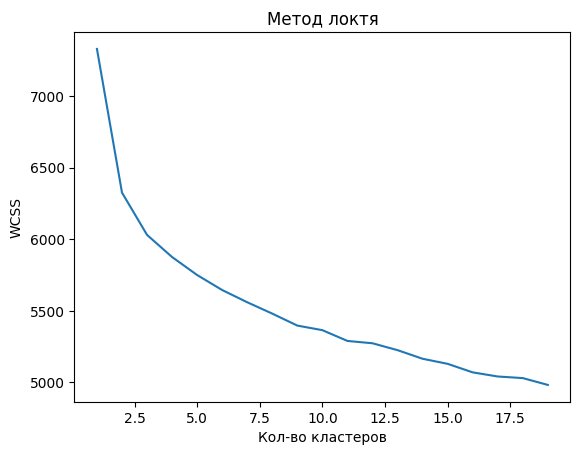

In [18]:
elbow_method(sample_normalize, range(1,20, 1))

Видим, что оптимальное количество кластеров в районе 2-3.

Проведем силуэтный анализ

In [19]:
def silhouette_method(data, range_n_clusters, step):
  list = []
  for n_clusters in range_n_clusters:
      cluster = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10, max_iter=300, random_state=0)
      cluster_labels = cluster.fit_predict(data)
      avg = silhouette_score(data, cluster_labels)
      list.append(avg)
      print(f"Для {n_clusters} кластеров усредненный силуэтный коэфф-т : {avg}")
  plt.figure(figsize=(6, 4))
  bar_width = step - 0.2
  bar_color = '#4daf4a'
  plt.bar(range_n_clusters, list, width=bar_width, color=bar_color)
  plt.xticks(range_n_clusters)
  plt.xlabel("Кол-во кластеров")
  plt.ylabel("Среднее силуэтного коэффициента")
  plt.title("Силуэтный анализ")
  plt.show()

Для 2 кластеров усредненный силуэтный коэфф-т : 0.21495232708280113
Для 3 кластеров усредненный силуэтный коэфф-т : 0.10179446049487732
Для 4 кластеров усредненный силуэтный коэфф-т : 0.048100147285026575
Для 5 кластеров усредненный силуэтный коэфф-т : 0.04907384066760788


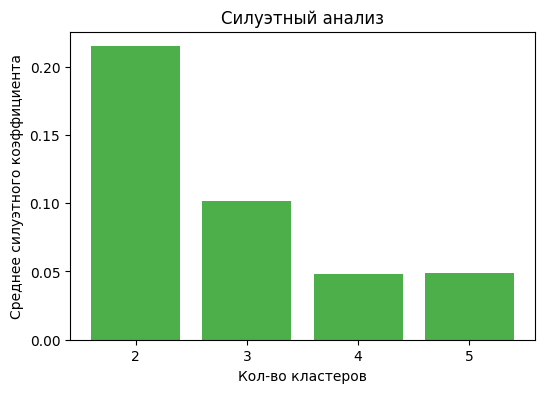

In [20]:
range_n_clusters = range(2,6, 1)
silhouette_method(sample_normalize, range_n_clusters=range_n_clusters, step=1)

Силуэтный анализ подтвердил нам наличие двух кластеров.

Далее создадим и обучим модель

In [21]:
kmeans = KMeans(n_clusters=2, init="k-means++", max_iter=300, random_state=0)
kmeans.fit(sample_normalize)

KMeans(n_clusters=2, random_state=0)

In [22]:
X_normalize = X_train

In [23]:
def top_func(data_norm, data, base_data):

  train_cluster_pred = kmeans.predict(data_norm)

  index_mapping = {i: idx for i, idx in enumerate(X_train.index)}

  cluster_index = {cluster: np.where(kmeans.labels_ == cluster)[0] for cluster in np.unique(kmeans.labels_)}

  accuracy = 0
  for cluster in tqdm(np.unique(train_cluster_pred), desc="Processing clusters"):
      base_cluster_index = cluster_index[cluster]
      base_cluster = base_data[base_cluster_index]
      train_cluster = data_norm[train_cluster_pred == cluster]
      true_labels_cluster = data[train_cluster_pred == cluster]['ID_sim']

      neighbors = NearestNeighbors(n_neighbors=5)
      neighbors.fit(base_cluster)

      _, index = neighbors.kneighbors(train_cluster)

      for target, idx in zip(true_labels_cluster.values.tolist(), index):
          text_index = [index_mapping[base_cluster_index[i]] for i in idx]
          accuracy += int(target in text_index)

  general_accuracy = 100 * accuracy / len(train)
  print(f"Total Accuracy: {general_accuracy:.2f}%")

In [33]:
top_func(X_normalize, train, base)

Processing clusters: 100%|██████████| 10/10 [00:19<00:00,  1.96s/it]

Total Accuracy: 60.80%


## 4. FAISS

Faiss - это инструмент, разработанный Facebook для быстрого поиска ближайших соседей в больших наборах данных.

Использование Faiss включает:
- подготовку данных  
- создание специального "индекса" для поиска  
- поиск ближайших соседей